In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astroquery

## BL Lac

In [2]:
ra = 330.680
dec = 42.2780

In [3]:
import astropy.coordinates as coord
import astropy.units as u
coords = coord.SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))
radius = 10*u.arcsec

In [4]:
from astroquery.ned import Ned
result_table = Ned.query_object("RXJ1754.1+3212")

In [5]:
result_table

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISE J175411.80+321223.1,268.54915,32.2064,RadioS,--,--,,1.58,--,39,0,29,18,0,0,0


In [6]:
from astropy.io import ascii
from astropy.table import Table

import sys
import re
import numpy as np
import pylab
import json
import requests

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib   

In [7]:
def ps1cone(ra,dec,radius,table="mean",release="dr2",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)


def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{baseurl}/{release}/{table}.{format}".format(**locals())
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))


def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = "{baseurl}/{release}/{table}/metadata".format(**locals())
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data
    """
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [8]:
meta = ps1metadata("mean","dr2")
meta

name,type,description
str17,str12,str142
objName,char,IAU name for this object.
objAltName1,char,Alternate name for this object.
objAltName2,char,Altername name for this object.
objAltName3,char,Altername name for this object.
objID,long,Unique object identifier.
uniquePspsOBid,long,Unique internal PSPS object identifier.
ippObjID,long,IPP internal object identifier.
surveyID,unsignedByte,Survey identifier. Details in the Survey table.
htmID,long,Hierarchical triangular mesh (Szalay 2007) index.


In [9]:
ra = ra
dec = dec
radius = 15.0/3600.0
constraints = {'nDetections.gt':1}

# strip blanks and weed out blank and commented-out values
columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag""".split(',')
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]
results = ps1cone(ra,dec,radius,release='dr2',columns=columns,verbose=True,**constraints)
# print first few lines
lines = results.split('\n')
print(len(lines),"rows in results -- first 5 rows:")
print('\n'.join(lines[:6]))

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?nDetections.gt=1&ra=330.68&dec=42.278&radius=0.004166666666666667&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%5D
9 rows in results -- first 5 rows:
objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
158733306835776586,330.68356985,42.27995169,98,14,18,41,17,8,19.637699127197266,18.69580078125,18.21540069580078,17.96489906311035,17.742799758911133
158733306815534409,330.68142213,42.27829535,2,1,0,1,0,0,19.976499557495117,-999.0,18.45210075378418,-999.0,-999.0
158733306804833997,330.68038444,42.27777354,97,12,18,40,17,10,15.711799621582031,15.00160026550293,13.776700019836426,13.309399604797363,13.197099685668945
158733306789831284,330.67897803,42.27552405,73,3,15,37,12,6,21.305099487304688,20.116500854492188,19.355499267578125,19.049400329589844,18.519899368286133
1587

In [10]:
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    try:
        tab[col].format = ".4f"
        tab[col][tab[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
158733306835776586,330.68356985,42.27995169,98,14,18,41,17,8,19.6377,18.6958,18.2154,17.9649,17.7428
158733306815534409,330.68142213,42.27829535,2,1,0,1,0,0,19.9765,nan,18.4521,nan,nan
158733306804833997,330.68038444,42.27777354,97,12,18,40,17,10,15.7118,15.0016,13.7767,13.3094,13.1971
158733306789831284,330.67897803,42.27552405,73,3,15,37,12,6,21.3051,20.1165,19.3555,19.0494,18.5199
158733306789472476,330.67891718,42.2765012,21,0,2,13,4,2,nan,20.1067,19.2945,18.8275,18.3525
158733306753383256,330.67532483,42.27718084,96,12,18,39,17,10,19.9299,18.8679,18.3779,18.1307,17.9407
158733306753273753,330.67532506,42.27752176,2,2,0,0,0,0,20.0516,nan,nan,nan,nan


In [14]:
#name
objname = 'BL Lac'
ra, dec = resolve(objname)
radius = 10.0/3600.0 # radius = 1 arcsec

results = ps1cone(ra,dec,radius,release='dr2',columns=columns,**constraints)
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    tab[col].format = ".4f"
    tab[col][tab[col] == -999.0] = np.nan
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
158733306789472476,330.67891718,42.2765012,21,0,2,13,4,2,nan,20.1067,19.2945,18.8275,18.3525
158733306789831284,330.67897803,42.27552405,73,3,15,37,12,6,21.3051,20.1165,19.3555,19.0494,18.5199
158733306804833997,330.68038444,42.27777354,97,12,18,40,17,10,15.7118,15.0016,13.7767,13.3094,13.1971
158733306815534409,330.68142213,42.27829535,2,1,0,1,0,0,19.9765,nan,18.4521,nan,nan


In [15]:
#Get the detect information

def addfilter(dtab):
    """Add filter name as column in detection table by translating filterID
    
    This modifies the table in place.  If the 'filter' column already exists,
    the table is returned unchanged.
    """
    if 'filter' not in dtab.colnames:
        # the filterID value goes from 1 to 5 for grizy
        id2filter = np.array(list('grizy'))
        dtab['filter'] = id2filter[(dtab['filterID']-1).data]
    return dtab

objid = tab['objID'][0]
dconstraints = {'objID': objid}
dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
            psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
# strip blanks and weed out blank and commented-out values
dcolumns = [x.strip() for x in dcolumns]
dcolumns = [x for x in dcolumns if x and not x.startswith('#')]

dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
dtab = addfilter(ascii.read(dresults))
dtab.sort('obsTime')
dtab

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str1
158733306789472476,132739390530002797,3,55428.3941716,330.67894124,42.27652755,7.845980144338682e-05,1.6620100495856605e-06,1.0175100564956665,0.9969480037689209,0.9981799721717834,0.00020932000188622624,1.6232199868682073e-06,102776839,128,40929344,i
158733306789472476,132740653530003086,3,55428.4068109,330.67894019,42.27652265,8.024489943636581e-05,1.6864299823282636e-06,1.0090199708938599,0.9722899794578552,0.9968820214271545,0.00019352500385139138,1.5637000387869193e-06,102776839,128,40929344,i
158733306789472476,132937001540003055,3,55430.3702825,330.6788964,42.27650702,6.434090028051287e-05,1.531509951746557e-06,0.8771340250968933,0.8117210268974304,0.9721840023994446,0.0001195150034618564,1.2247900258444133e-06,102776839,128,7374912,i
158733306789472476,132938270530003169,3,55430.3829766,330.67892075,42.27650441,6.000489884172566e-05,1.4820800515735755e-06,0.7806239724159241,0.7559710144996643,0.9993489980697632,0.00013817699800711125,1.3256600368549698e-06,102776839,128,7374912,i
158733306789472476,132939723530003738,2,55430.3974693,330.6789265,42.27651025,3.0747400160180405e-05,1.558699977977085e-06,0.9739829897880554,0.8949009776115417,0.971235990524292,7.754840044071898e-05,1.0038299933512462e-06,102776839,128,7374912,r
158733306789472476,132940917530003173,2,55430.4094169,330.67888847,42.27649411,3.4861899621319026e-05,1.6418899804193643e-06,1.0958399772644043,0.9577869772911072,0.9979259967803955,9.70921028056182e-05,1.1154299954796443e-06,35667969,0,74483776,r
158733306789472476,133046309420003075,3,55431.4633557,330.67892778,42.2765015,8.82121967151761e-05,2.4371599920414155e-06,1.254040002822876,1.1831200122833252,0.6796960234642029,0.0002471629995852709,1.9355300082679605e-06,102776839,160,2112,i
158733306789472476,162560930650003115,4,55726.6094865,330.67890814,42.2764927,0.00010455199662828818,2.6339500891481293e-06,0.8627439737319946,0.8269439935684204,0.9985780119895935,0.00017270000535063446,2.158800043616793e-06,102776839,128,108038208,z
158733306789472476,162561394650003511,4,55726.6141212,330.67889576,42.27648678,0.00010673500219127163,2.6825400709640235e-06,0.9106060266494751,0.875557005405426,0.9976540207862854,0.00025343798915855587,2.5884698970912723e-06,102776839,128,7374912,z


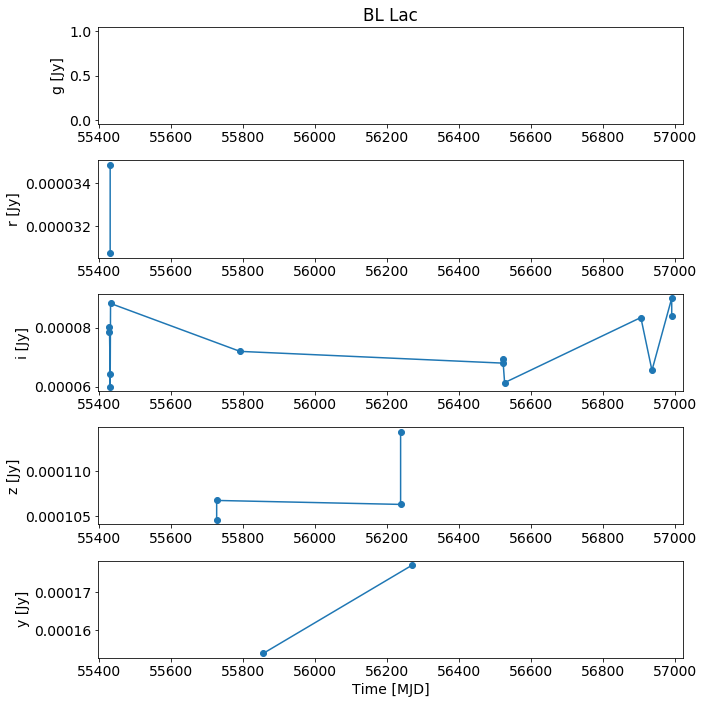

In [16]:
#plot lc 
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

flux = dtab["psfFlux"]

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    pylab.plot(t[w],flux[w],'-o')
    pylab.ylabel(filter+' [Jy]')
    pylab.xlim(xlim)
    #pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()